# Imbalanced classes

What can we do if we have unbalanced classes, ie, if one class that is much rarer than the other, or if one class is more important to us than another?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
import sklearn.datasets
import sklearn.utils
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

We download the [Lending Club Loan Dataset](https://www.openml.org/search?type=data&sort=runs&id=43729&status=active) from openml. It's a dataset on loans, the target variable captures whether the loan was fully paid back or not.

In [2]:
data=sklearn.datasets.fetch_openml(data_id=43729,target_column="not.fully.paid",parser='auto')

Let's print the description.

In [3]:
print(data.DESCR)

Context
I wanted a highly imbalanced dataset to share with others. It has the perfect one for us.
Imbalanced data typically refers to a classification problem where the number of observations per class is not equally distributed; often you'll have a large amount of data/observations for one class (referred to as the majority class), and much fewer observations for one or more other classes (referred to as the minority classes). 
For example, In this dataset, There are way more samples of fully paid borrowers versus not fully paid borrowers. 
Full LendingClub data available from their site.
Content
For companies like Lending Club correctly predicting whether or not a loan will be default is very important. This dataset contains historical data from 2007 to 2015, you can to build a deep learning model to predict the chance of default for future loans. As you will see this dataset is highly imbalanced and includes a lot of features that make this problem more challenging.

Downloaded from

We split the data into a training set and a test set. At the same time we shuffle the data.

In [4]:
X_train,X_test,y_train,y_test=train_test_split(data.data,data.target,train_size=7000,shuffle=True)

Let's see whether we really have imbalanced classes:

In [5]:
sum(y_train==1),sum(y_train==0)

(1132, 5868)

Indeed, there are many more instances of class 0 (people paying back their loan) than instances of class 1 (people defaulting on their loan).

Let's have a peek at the training data:

In [6]:
X_train.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
5053,1,debt_consolidation,0.1426,686.12,11.225243,8.02,687,3479.958333,15278,76.4,3,0,0
7870,0,home_improvement,0.1407,191.59,9.615805,2.00,642,238.958333,852,77.5,5,0,0
4856,1,credit_card,0.0859,202.31,10.734220,15.24,747,8400.000000,13010,36.8,0,0,0
7899,0,debt_consolidation,0.1154,131.99,9.825526,1.30,667,2910.000000,258,86.0,2,0,0
9559,0,credit_card,0.1273,688.11,11.314475,21.13,732,5881.000000,35227,54.3,5,0,0


Aha, seems like <code>X_train["purpose"]</code> has string values. Let's verify that this is the only field.

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 5053 to 8962
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      7000 non-null   int64  
 1   purpose            7000 non-null   object 
 2   int.rate           7000 non-null   float64
 3   installment        7000 non-null   float64
 4   log.annual.inc     7000 non-null   float64
 5   dti                7000 non-null   float64
 6   fico               7000 non-null   int64  
 7   days.with.cr.line  7000 non-null   float64
 8   revol.bal          7000 non-null   int64  
 9   revol.util         7000 non-null   float64
 10  inq.last.6mths     7000 non-null   int64  
 11  delinq.2yrs        7000 non-null   int64  
 12  pub.rec            7000 non-null   int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 765.6+ KB


We check how many different values the column <code>"purpose"</code> takes.

In [8]:
X_train["purpose"].unique()

array(['debt_consolidation', 'home_improvement', 'credit_card',
       'all_other', 'major_purchase', 'small_business', 'educational'],
      dtype=object)

Only a few -- that's good because that means we can one-hot encode the column (ie, replace the string values by unit vectors) without blowing up the dimensionality of the data. Because we only need to one-hot encode *one* column of the data, we wrap the <code>OneHotEncoder</code> into a <code>ColumnTransformer</code>, which then is applied to only the column <code>"purpose"</code>. 

For classification we use a simple classifier, namely a random forest. We could have chosen any other classifier as we're here only interested in demonstrating the effect of a class imbalance. Both the <code>OneHotEncoder</code> and <code>RandomForestClassifier</code> are merged to a <code>Pipeline</code>, an object hat looks from the outside like a simple classifier but that actually performs two steps, namely the transformation and the classification, every time <code>predict</code> (or <code>fit</code>) is called.

In [9]:
col_trans=make_column_transformer((OneHotEncoder(),['purpose']),remainder='passthrough')
rf=RandomForestClassifier()
classifier=Pipeline([('one hot',col_trans),('random forest',rf)])

We fit the whole pipeline.

In [10]:
classifier.fit(X_train,y_train)

Pipeline(steps=[('one hot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['purpose'])])),
                ('random forest', RandomForestClassifier())])

Let's check the accuracy.

In [11]:
y_pred=classifier.predict(X_test)
sklearn.metrics.accuracy_score(y_pred,y_test)

0.843289371605896

Not great but respectable. However, as there are more instance of class 0, it's easy to achieve high accuracy by **always** predicting 0. So let's calculate the *true positive rate* (the fraction of positive instances that are recognised as positive) and the *true negative rate* (the fraction of negative instances that are recognised as negative).

Again, more formally, let's denote by
* *tp*: the number of instances of class 1 that are correctly predicted to be 1
* *fp*: the number of instances of class 0 that are incorrectly predicted to be 1
* *tn*: the number of instances of class 0 that are correctly predicted to be 0
* *fn*: the number of instances of class 1 that are incorrectly predicted to be 0
Then
$$ tpr=\frac{tp}{tp+fn} \text{ and } tnr=\frac{tn}{tn+fp}$$

In [12]:
tpr=sum(y_pred*y_test)/sum(y_test)
tnr=sum((1-y_pred)*(1-y_test))/sum(1-y_test)
tpr,tnr

(0.0199501246882793, 0.9949471750114837)

Aha. *True negative rate* is excellent: we detect almost all cases when a loan is paid back. *True positive rate*, however, is quite low -- we rarely detect a default on the loan. That is clearly bad.

To get a more complete picture we compute a *ROC curve*, a *Receiver operating characteristic* curve. (According to Wikipedia ROC curves where first conceived during World War II in the context of radar detection of enemy fighter planes, which may explain the weird name.) The ROC curve plots *false positive rate* against *true positive rate*, where *false positive rate* is the complement of *true negative rate*, ie, $fpr=1-tnr$. That means, ideally, we'd like *true positive rate* to be large and *false positive rate* to be small.

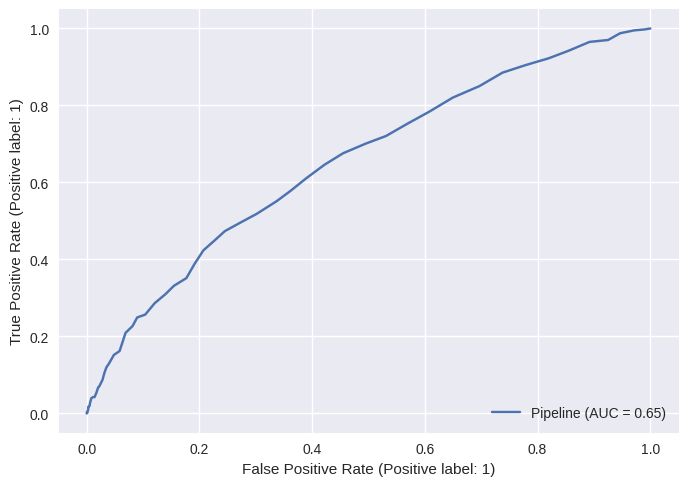

In [13]:
disp=sklearn.metrics.RocCurveDisplay.from_estimator(classifier,X_test,y_test,pos_label=1)

That does not look good. 

How is the ROC curve computed? The classifier outputs for each sample a score in [0,1] that may be interpreted as its confidence how likely it is that the sample belongs to class 1. Normally, we'd classify a sample as 1 if the score is at least 0.5. Now, we can make it harder, or easier, for a sample to be classified as 1 by moving that threshold 0.5. This is used to compute the ROC curve: for each possible threshold the $tpr$ and $fpr$ is computed and then plotted. 

We can use this obviously to calibrate the classifier. Let's say that we deem a *false positive rate* of at most 30% as acceptable. We can now search for a threshold level that yields $fpr\leq 0.4$ and a $tpr$ as large as possible.

In [14]:
y_scores=classifier.predict_proba(X_test)[:,1]
fprs,tprs,thresholds=sklearn.metrics.roc_curve(y_test,y_scores,pos_label=1)

Let's extract the threshold that corresponds to at most 30% $fpr$.

In [15]:
index=np.argmin(np.where(fprs<=0.3,thresholds,np.inf))
threshold=thresholds[index]
threshold,tprs[index],fprs[index]

(0.22, 0.49625935162094764, 0.2733118971061093)

We modify our classifier and compute $tpr$ and $tnr$ again.

In [16]:
def predict(X):
    return classifier.predict_proba(X)[:,1]>=threshold

y_pred=predict(X_test)
tpr=sum(y_pred*y_test)/sum(y_test)
tnr=sum((1-y_pred)*(1-y_test))/sum(1-y_test)
tpr,tnr

(0.49625935162094764, 0.7266881028938906)

We have boosted $tpr$ by a lot by sacrificing a good chunk of $tnr$.